In [1]:

# Magic function that will make your plot outputs appear and be stored within the notebook
%matplotlib inline

# Function used to to render higher resolution images
%config InlineBackend.figure_format = 'retina'
%pip install pyarrow        ### pyarrow and fastparquet are new to me: these are necessary for loading parquet file data
%pip install fastparquet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D





Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
def plot_particle_trajectory(event_id, sensor_data_df, sensor_geometry_df, auxiliary=False):
    # Filter sensor data for the given event_id
    event_sensors = sensor_data_df[sensor_data_df.index == event_id]
    print('STARTING SENSOR NUMBER: '+str(event_sensors.shape))
    sensor_coordinates = sensor_geometry_df[['x', 'y', 'z']]
    # x_all = sensor_coordinates['x'].values
    # y_all = sensor_coordinates['y'].values
    # z_all = sensor_coordinates['z'].values
    x_all = sensor_coordinates['x']
    y_all = sensor_coordinates['y']
    z_all = sensor_coordinates['z']
    charges = event_sensors['charge']

    # Get event sensor coordinates based on auxiliary option
    if auxiliary:

        auxiliary_sensor_ids = event_sensors[event_sensors['auxiliary'] == True]
        event_sensor_coordinates = sensor_geometry_df[sensor_geometry_df.index.isin(auxiliary_sensor_ids['sensor_id'])]
        event_sensors = auxiliary_sensor_ids
        charges = auxiliary_sensor_ids['charge']
        times = auxiliary_sensor_ids['time']
        print('AUX SENSOR NUMBER: '+str(charges.shape))

    else:
        event_sensor_coordinates = sensor_geometry_df[sensor_geometry_df.index.isin(event_sensors['sensor_id'])]
        charges = event_sensors['charge']
        times = event_sensors['time']


    print(event_sensors['charge'].shape)
    charge_min = np.min(charges)
    charge_max = np.max(charges)
    marker_sizes = 5 + (100 * ((charges - charge_min) / (charge_max - charge_min)) ) # Adjust the range of marker sizes as needed

    print(event_sensor_coordinates['x'].shape, event_sensor_coordinates['y'].shape, event_sensor_coordinates['z'].shape,marker_sizes.shape)
    # Create a 3D plot
    fig = plt.figure(facecolor='#eaeaf2')
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_all, y_all, z_all, c='gray', marker='o', s = 1, alpha = .1)

    # Plot the triggered sensors with markers
    ax.scatter(event_sensor_coordinates['x'], event_sensor_coordinates['y'], event_sensor_coordinates['z'], marker='o', s=marker_sizes, c=times)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'True Reconstruction for Event {event_id}')

    # Show the plot
    # plt.show()
    fig.show()







        

In [3]:
datapath = '../../IceCube_Training_Data/'                                                   ### Adjust your path to match where you are keeping the parquet files
batch_list = [pd.read_parquet(datapath+'batch_'+str(i)+'.parquet') for i in range(1,6)]     ### I renamed the parquet files so I could easily loop over them and aggregate the events
rawdata = pd.concat(batch_list)
events = rawdata.index.drop_duplicates()

print(rawdata.head())




          sensor_id  time  charge  auxiliary
event_id                                    
24             3918  5928   1.325       True
24             4157  6115   1.175       True
24             3520  6492   0.925       True
24             5041  6665   0.225       True
24             2948  8054   1.575       True


In [4]:
rawdata_meta = pd.read_parquet('../../train_meta.parquet')
rawdata_meta = rawdata_meta.loc[rawdata_meta['event_id'].isin(events)]
print(rawdata_meta.head())

   batch_id  event_id  first_pulse_index  last_pulse_index   azimuth    zenith
0         1        24                  0                60  5.029555  2.087498
1         1        41                 61               111  0.417742  1.549686
2         1        59                112               147  1.160466  2.401942
3         1        67                148               289  5.845952  0.759054
4         1        72                290               351  0.653719  0.939117


(35,) (35,) (35,) (35,)


/var/folders/pc/9_dvbgps3y57jd1wx7t5lp640000gn/T/ipykernel_25999/1445579668.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


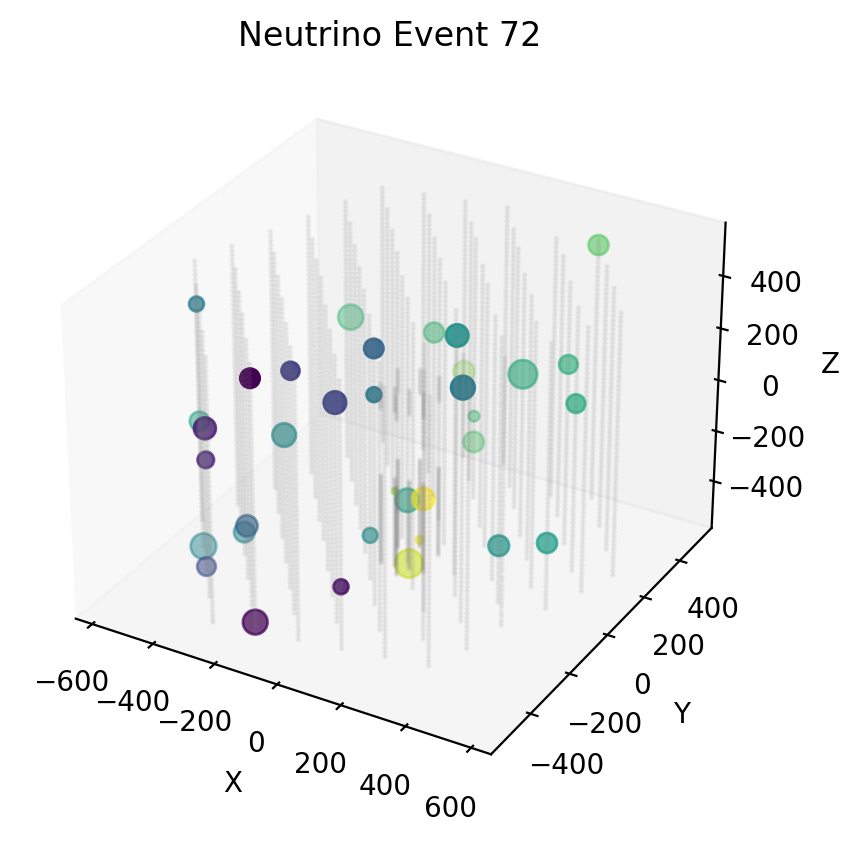

In [79]:
def plot_particle_trajectory(event_id, sensor_data_df, sensor_geometry_df, auxiliary=False):
    # Filter sensor data for the given event_id
    event_sensors = sensor_data_df[sensor_data_df.index == event_id]

    x_all = sensor_geometry_df['x'].values
    y_all = sensor_geometry_df['y'].values
    z_all = sensor_geometry_df['z'].values

    # Get event sensor coordinates based on auxiliary option
    if auxiliary:

        auxiliary_sensor_ids = event_sensors[event_sensors['auxiliary'] == True]
        auxiliary_sensor_ids = auxiliary_sensor_ids.drop_duplicates(subset=['sensor_id'])    
        event_sensor_coordinates = sensor_geometry[sensor_geometry.index.isin(auxiliary_sensor_ids['sensor_id'])]
        charges = auxiliary_sensor_ids['charge'].values
        times = auxiliary_sensor_ids['time'].values


    else:
        event_sensors = event_sensors.drop_duplicates(subset=['sensor_id'])
        event_sensor_coordinates = sensor_geometry_df[sensor_geometry_df.index.isin(event_sensors['sensor_id'])]
        charges = event_sensors['charge'].values
        times = event_sensors['time'].values
        print('len charges: '+str(charges.shape))

    charge_min = np.min(charges)
    charge_max = np.max(charges)
    marker_sizes = 5 + (100 * ((charges - charge_min) / (charge_max - charge_min)) ) # Adjust the range of marker sizes as needed

    print(event_sensor_coordinates['x'].shape, event_sensor_coordinates['y'].shape, event_sensor_coordinates['z'].shape,marker_sizes.shape)
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_all, y_all, z_all, c='gray', marker='o', s = 1, alpha = .1)

    # Plot the triggered sensors with markers
    ax.scatter(event_sensor_coordinates['x'].values, event_sensor_coordinates['y'].values, event_sensor_coordinates['z'].values, marker='o', s=marker_sizes, c=times)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Neutrino Event {event_id}')
    ax.grid(False)

    # Show the plot
    # plt.show()
    fig.show()


sensor_geometry = pd.read_csv('../../sensor_geometry.csv').set_index('sensor_id')
plot_particle_trajectory(72, rawdata, sensor_geometry, auxiliary=True)



In [69]:

event_sensors = rawdata[rawdata.index == 41]

# auxiliary_sensor_ids = event_sensors[event_sensors['auxiliary'] == True]
# print(auxiliary_sensor_ids.head())

# event_sensor_coordinates = sensor_geometry[sensor_geometry.index.isin(auxiliary_sensor_ids['sensor_id'])]

# print(event_sensor_coordinates.head())
# print(auxiliary_sensor_ids['charge'].head())

auxiliary = False

if auxiliary:

    auxiliary_sensor_ids = event_sensors[event_sensors['auxiliary'] == True]
    auxiliary_sensor_ids = auxiliary_sensor_ids.drop_duplicates(subset=['sensor_id'])    
    print('auxiliary_sensor_ids: '+str(auxiliary_sensor_ids.shape))
    event_sensor_coordinates = sensor_geometry[sensor_geometry.index.isin(auxiliary_sensor_ids['sensor_id'])]
    charges = auxiliary_sensor_ids['charge'].values
    times = auxiliary_sensor_ids['time'].values
    print('event_sensor_coordinates: '+str(event_sensor_coordinates['x'].shape))
    print('charges: '+str(charges.shape))


else:
    event_sensor_coordinates = sensor_geometry[sensor_geometry.index.isin(event_sensors['sensor_id'])]
    charges = event_sensors['charge'].values
    times = event_sensors['time'].values



charge_min = np.min(charges)
charge_max = np.max(charges)
marker_sizes = 5 + (100 * ((charges - charge_min) / (charge_max - charge_min)) ) # Adjust the range of marker sizes as needed




# print(auxiliary_sensor_ids['sensor_id'])

print(len(marker_sizes))
# print(marker_sizes)





51


In [64]:

auxiliary_sensor_ids.drop_duplicates(subset=['sensor_id'])
a = list(auxiliary_sensor_ids['sensor_id'].values)
b = list(event_sensor_coordinates.index.values)

print(a.sort())
print(b.sort())

print(a)
print(b)

None
None
[171, 458, 492, 502, 607, 690, 752, 763, 919, 1028, 1151, 1287, 1836, 1911, 1938, 2142, 2152, 2214, 2681, 2824, 3361, 3668, 3832, 3840, 4065, 4083, 4107, 4107, 4107, 4148, 4312, 4440, 4503, 4594, 4739, 4811, 4892, 5067]
[171, 458, 492, 502, 607, 690, 752, 763, 919, 1028, 1151, 1287, 1836, 1911, 1938, 2142, 2152, 2214, 2681, 2824, 3361, 3668, 3832, 3840, 4065, 4083, 4107, 4148, 4312, 4440, 4503, 4594, 4739, 4811, 4892, 5067]


In [62]:
auxiliary_sensor_ids.drop_duplicates(subset=['sensor_id'])

,sensor_id,time,charge,auxiliary
event_id,,,,
41,458,6469,0.925,True
41,4107,6975,1.175,True
41,502,8010,0.775,True
41,2824,8730,0.825,True
41,607,9322,1.075,True
41,1938,9389,0.725,True
41,763,9390,1.475,True
41,4811,9687,1.425,True
41,1911,9843,0.725,True


In [33]:
# for i in auxiliary_sensor_ids['sensor_id'].values:
#     if i not in event_sensor_coordinates.index.values:
#         print(i)

set1 = set(auxiliary_sensor_ids['sensor_id'].values)
set2 = set(event_sensor_coordinates.index.values)

missing = list(sorted(set1 - set2))
added = list(sorted(set2 - set1))

print(missing)
print(added)
print(set1)
print(set2)


[]
[]
{3840, 4739, 1028, 1287, 2824, 4107, 1938, 919, 4503, 4892, 3361, 2214, 171, 1836, 690, 4148, 458, 4811, 5067, 3668, 4440, 4312, 2142, 607, 4065, 2152, 492, 752, 4594, 4083, 502, 1911, 3832, 2681, 763, 1151}
{3840, 4739, 1028, 1287, 2824, 4107, 1938, 919, 4503, 4892, 3361, 2214, 171, 1836, 690, 4148, 458, 4811, 5067, 3668, 4312, 4440, 2142, 607, 4065, 2152, 492, 752, 4594, 4083, 502, 1911, 3832, 2681, 763, 1151}


In [48]:
event_sensor_coordinates

,x,y,z
sensor_id,,,
171,-9.13,-481.74,-368.82
458,-211.35,-404.48,-148.16
492,-88.05,-384.30,295.77
502,-88.05,-384.30,125.56
607,158.94,-345.23,380.69
690,282.18,-325.74,-12.18
752,405.83,-306.38,-49.53
763,405.83,-306.38,-236.76
919,-166.40,-287.79,174.26


STARTING SENSOR NUMBER: (51, 4)
(51,)
(45,) (45,) (45,) (51,)


ValueError: s must be a scalar, or float array-like with the same size as x and y

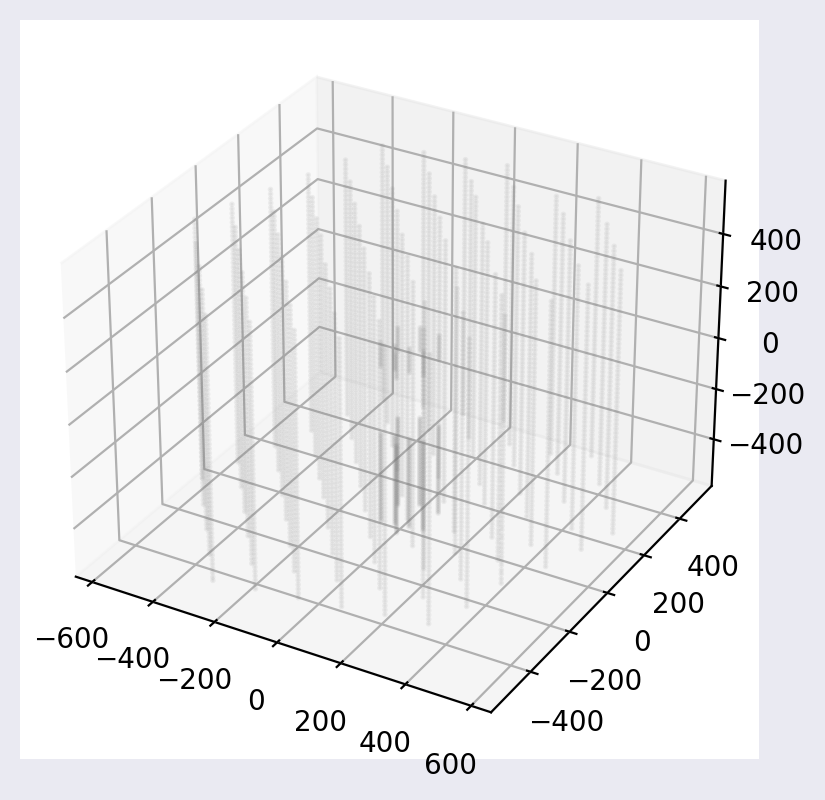

In [30]:

# Load the sensor data, directional data, and sensor geometry data into pandas dataframes

sensor_geometry = pd.read_csv('../../sensor_geometry.csv').set_index('sensor_id')

# Call the function to plot the particle trajectory for a specific event_id
plot_particle_trajectory(41, rawdata, sensor_geometry, auxiliary=False)
